<a href="https://colab.research.google.com/github/ahmedebeed555/deeplearning/blob/main/Me_TonyAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# ==========================
# STEP 1: Install dependencies
# ==========================
!pip install speechbrain torchaudio librosa scikit-learn soundfile

# ==========================
# STEP 2: Imports
# ==========================
import os
import librosa
import soundfile as sf
import numpy as np
import torch
import torchaudio
from speechbrain.pretrained import EncoderClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ==========================
# STEP 3: Load pretrained speaker encoder
# ==========================
encoder = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

def get_embedding(file):
    signal, fs = torchaudio.load(file)
    embedding = encoder.encode_batch(signal)
    return embedding.squeeze().detach().numpy()

# ==========================
# STEP 4: Function to split audio into chunks
# ==========================
def split_audio(file, out_dir, chunk_length=3.0, sr=16000):
    os.makedirs(out_dir, exist_ok=True)
    y, _ = librosa.load(file, sr=sr)
    samples_per_chunk = int(chunk_length * sr)
    chunk_files = []
    for i in range(0, len(y), samples_per_chunk):
        chunk = y[i:i+samples_per_chunk]
        if len(chunk) < samples_per_chunk:
            break
        chunk_file = os.path.join(out_dir, f"chunk_{i//samples_per_chunk}.wav")
        sf.write(chunk_file, chunk, sr)
        chunk_files.append(chunk_file)
    return chunk_files

# ==========================
# STEP 5: Prepare dataset
# ==========================
your_file = "/content/drive/MyDrive/AI Sessions/you_long.wav"      # replace with your file
tony_file = "/content/drive/MyDrive/AI Sessions/tony_long.wav"   # replace with Tony file

your_chunks = split_audio(your_file, "chunks/you", chunk_length=3.0)
tony_chunks = split_audio(tony_file, "chunks/tony", chunk_length=3.0)

X, y = [], []

for file in your_chunks:
    X.append(get_embedding(file))
    y.append(0)  # you = 0

for file in tony_chunks:
    X.append(get_embedding(file))
    y.append(1)  # Tony = 1

X = np.array(X)
y = np.array(y)

# ==========================
# STEP 6: Train/test split & model
# ==========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["You", "Tony"]))



INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Fetching files for pretraining (no collection directory set)
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /root/.cache/hugg

              precision    recall  f1-score   support

         You       1.00      1.00      1.00        31
        Tony       1.00      1.00      1.00        30

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



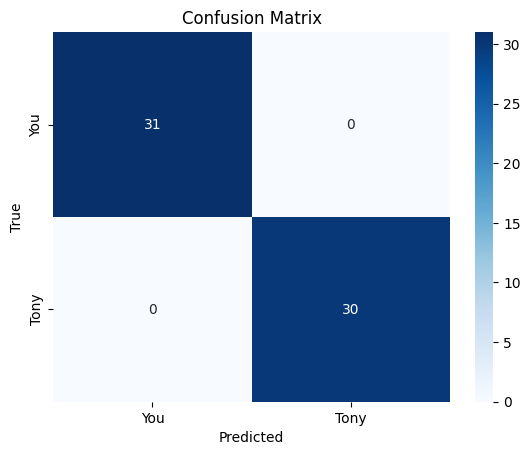

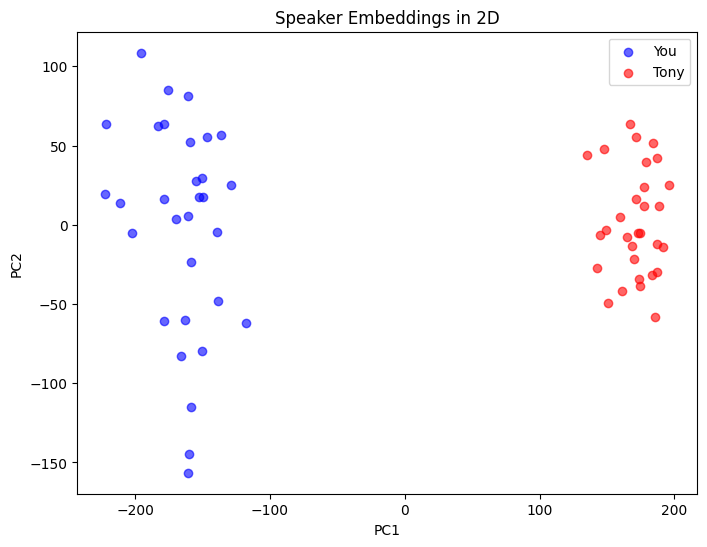

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# ---- Confusion Matrix ----
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["You", "Tony"], yticklabels=["You", "Tony"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ---- Embedding Visualization ----
# Assume you stored embeddings in X_test (shape: [n_samples, n_features])
# Reduce high-d embeddings to 2D with PCA (or use TSNE for nonlinear)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_test)

# Plot with colors based on true labels
plt.figure(figsize=(8,6))
for label, color, name in zip([0, 1], ["blue", "red"], ["You", "Tony"]):
    idx = np.where(y_test == label)
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], c=color, label=name, alpha=0.6)

plt.legend()
plt.title("Speaker Embeddings in 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


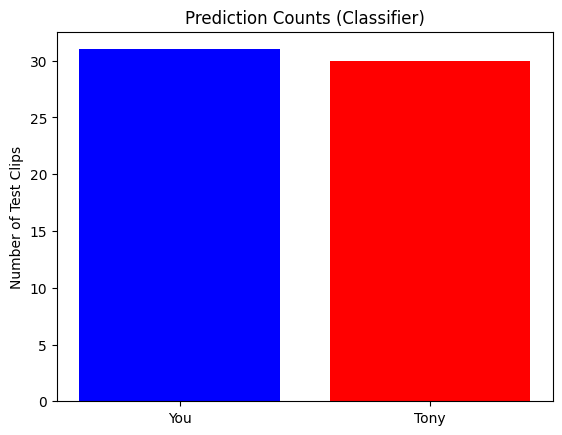

In [7]:
import numpy as np

labels = ["You", "Tony"]
counts = [np.sum(y_pred == 0), np.sum(y_pred == 1)]

plt.bar(labels, counts, color=["blue", "red"])
plt.title("Prediction Counts (Classifier)")
plt.ylabel("Number of Test Clips")
plt.show()


In [8]:
# ==========================
# STEP 7: Test new audio
# ==========================
test_file = "/content/drive/MyDrive/AI Sessions/test.wav"   # replace with your test audio
test_embed = get_embedding(test_file).reshape(1, -1)
prediction = clf.predict(test_embed)[0]
print("Prediction:", "Tony" if prediction == 1 else "You")


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Prediction: Tony


In [1]:
!pip install speechbrain torchaudio librosa scikit-learn soundfile


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 40.9 MB/s eta 0:00:00


# Cosine Similarity : Embedding

In [9]:

import torch
import torchaudio
from speechbrain.pretrained import EncoderClassifier
import torch.nn.functional as F

# Load pre-trained speaker recognition model
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

def get_embedding(path):
    # Load audio
    signal, fs = torchaudio.load(path)
    # If stereo, convert to mono
    if signal.shape[0] > 1:
        signal = signal.mean(dim=0, keepdim=True)
    # Resample to 16kHz if needed
    if fs != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=fs, new_freq=16000)
        signal = resampler(signal)
    # Get embedding
    embedding = classifier.encode_batch(signal)
    return embedding.mean(dim=1)  # average over time

# Get embeddings for reference speakers
you_emb = get_embedding("/content/drive/MyDrive/AI Sessions/you_long.wav")
tony_emb = get_embedding("/content/drive/MyDrive/AI Sessions/tony_long.wav")

# Get embedding for test clip
test_emb = get_embedding("/content/drive/MyDrive/AI Sessions/test.wav")

# Cosine similarity comparison
sim_you = F.cosine_similarity(test_emb, you_emb).item()
sim_tony = F.cosine_similarity(test_emb, tony_emb).item()

print("Similarity with YOU:", sim_you)
print("Similarity with TONY:", sim_tony)

if sim_you > sim_tony:
    print("Prediction: YOU")
else:
    print("Prediction: TONY")


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Fetching files for pretraining (no collection directory set)
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-ecapa-voxceleb/snapshots/0f99f2d0ebe89ac095bcc5903c4dd8f72b367286/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-ecapa-voxceleb' if not cached
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /root/.cache/hugg

Similarity with YOU: 0.6696535348892212
Similarity with TONY: 0.057234957814216614
Prediction: YOU


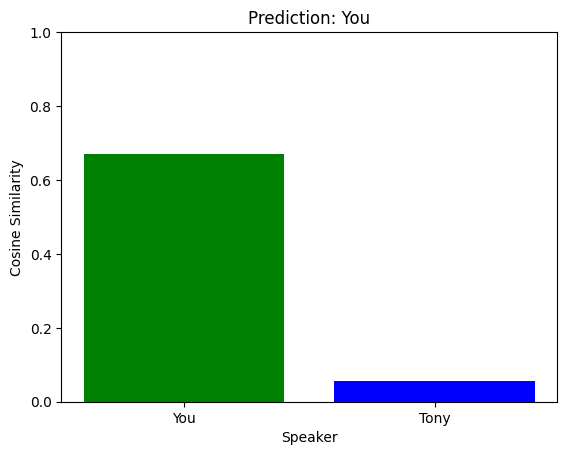

In [4]:
import matplotlib.pyplot as plt

# Similarity scores from the cosine similarity code
scores = {"You": sim_you, "Tony": sim_tony}

# Find predicted speaker
predicted = max(scores, key=scores.get)

# Plot bar chart
plt.bar(scores.keys(), scores.values(), color=["blue" if s!=predicted else "green" for s in scores.keys()])
plt.xlabel("Speaker")
plt.ylabel("Cosine Similarity")
plt.title(f"Prediction: {predicted}")
plt.ylim(0, 1)  # cosine similarity is between -1 and 1
plt.show()
